In [141]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.applications.xception import Xception
from keras.applications import *
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from PIL import Image
import random
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier 
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.decomposition import PCA

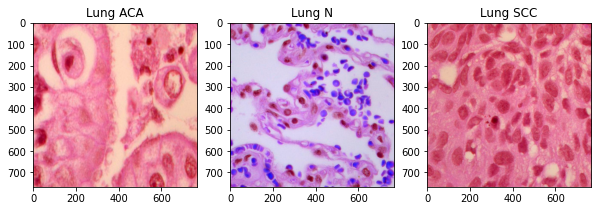

In [142]:
lung_aca = "../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/"

plt.figure(figsize = (10, 10))
plt.subplot(131)
img = cv2.imread(lung_aca + os.listdir(lung_aca)[0])
plt.title('Lung ACA')
plt.imshow(img)

plt.subplot(132)
lung_n = "../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n/"
img = cv2.imread(lung_n + os.listdir(lung_n)[0])
plt.title('Lung N')
plt.imshow(img)

plt.subplot(133)
lung_scc = "../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc/"
img = cv2.imread(lung_scc + os.listdir(lung_scc)[0])
plt.title('Lung SCC')
plt.imshow(img)
plt.show()

In [143]:
data_dir = "../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/"
SIZE_X = SIZE_Y = 128

datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.3)

train_it = datagen.flow_from_directory(data_dir,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 12, 
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)

validate_it = datagen.flow_from_directory(data_dir,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X, SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 12, 
                                       shuffle = False,
                                       subset='validation',
                                       seed = 42)

Found 10500 images belonging to 3 classes.
Found 4500 images belonging to 3 classes.


In [144]:
def get_features(base_model, train, validate):
    X_train = base_model.predict(train)
    y_train = train.classes

    X_val = base_model.predict(validate)
    y_val = validate.classes

    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = True)
    print('Shape of X_train----->', str(X_train.shape))
    print('Shape of X_val----->', str(X_val.shape))
    print('Shape of X_test----->', str(X_test.shape))
    return (X_train, X_val, X_test, y_train, y_val, y_test)

In [145]:
def get_models():
    ANN = Sequential()
    ANN.add(Dense(128, input_dim = X_train.shape[1], activation = 'relu'))
    ANN.add(BatchNormalization())
    ANN.add(Dropout(0.2))
    ANN.add(Dense(64, activation='relu'))
    ANN.add(Dense(32, activation='relu'))
    ANN.add(Dense(16, activation='relu'))
    ANN.add(Dense(8, activation='relu'))
    ANN.add(Dense(len(train_it.class_indices), activation='softmax'))
    ANN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    KNN = KNeighborsClassifier()
    
    SVM = SVC(kernel = 'linear')
    
    RF = RandomForestClassifier(n_estimators = 50)
    
    ADB = AdaBoostClassifier()
    
    XGB = XGBClassifier(n_estimators = 50, use_label_encoder=False)
    
    print("Defined------->")
    print("ANN -------->", "(128x64x32x16x8)")
    print("KNeighborsClassifier()")
    print("SVC(kernel = 'linear')")
    print("RandomForestClassifier(n_estimators = 50)")
    print("AdaBoostClassifier()")
    print("XGBClassifier(n_estimators = 50)")
    
    return (ANN, KNN, SVM, RF, ADB, XGB)

In [146]:
def reshape_data(X_train, X_val, X_test):
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val = X_val.reshape(X_val.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    print("Shape after reshaping------->")
    print("X train------->", str(X_train.shape))
    print("X val-------->", str(X_val.shape))
    print("X test-------->", str(X_test.shape))
    
    return (X_train, X_val, X_test)

In [147]:
def fit_ANN(model, X_train, y_train, X_val, y_test):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_test), epochs=10, verbose=1, callbacks=[es])
    return model

def fit_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def get_accuracy_metrics_for_ANN(model, X_train, y_train, X_val, y_val, X_test, y_test):
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(y_train, np.argmax(model.predict(X_train), axis = 1))*100), "%")
    
    print("Val accuracy Score--------->")
    val_pred = np.argmax(model.predict(X_val), axis = 1)
    print("{0:.3f}".format(accuracy_score(y_val, val_pred)*100), "%")
    
    predicted =  np.argmax(model.predict(X_test), axis = 1)
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, predicted)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, predicted)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, predicted, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, predicted)
    cf_matrix_val = confusion_matrix(y_val, val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

In [148]:
def fit_KNN_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    pca = PCA(n_components=7000)
    randlist = random.sample(range(0, X_train.shape[0]), 1000)
    if(X_train.shape[1] > 10000):
        X_train = pca.fit_transform(X_train)
        X_val = pca.transform(X_val)
        X_test = pca.transform(X_test)

    model.fit(X_train, y_train)
    get_accuracy_metrics(model, X_train[randlist, :], y_train[randlist], X_val, y_val, X_test, y_test)
    
def get_accuracy_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(y_train, model.predict(X_train))*100), "%")
    
    print("Val accuracy Score--------->")
    val_pred = model.predict(X_val)
    print("{0:.3f}".format(accuracy_score(y_val, val_pred)*100), "%")
    
    predicted =  model.predict(X_test)
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, predicted)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, predicted)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, predicted, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, predicted)
    cf_matrix_val = confusion_matrix(y_val, val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

In [149]:

base_model = Xception(include_top=False, input_shape=(SIZE_X, SIZE_Y, 3), weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
___________________________

# VGG 16

In [150]:
X_train, X_val, X_test, y_train, y_val, y_test = get_features(model, train_it, validate_it)

Shape of X_train-----> (10500, 4, 4, 2048)
Shape of X_val-----> (2250, 4, 4, 2048)
Shape of X_test-----> (2250, 4, 4, 2048)


In [151]:
X_train, X_val, X_test = reshape_data(X_train, X_val, X_test)
ANN, KNN, SVM, RF, ADB, XGB = get_models()

ANN = fit_ANN(ANN, X_train, y_train, X_val, y_val)

Shape after reshaping------->
X train-------> (10500, 32768)
X val--------> (2250, 32768)
X test--------> (2250, 32768)
Defined------->
ANN --------> (128x64x32x16x8)
KNeighborsClassifier()
SVC(kernel = 'linear')
RandomForestClassifier(n_estimators = 50)
AdaBoostClassifier()
XGBClassifier(n_estimators = 50)
Epoch 1/10
329/329 [==============================] - 3s 6ms/step - loss: 0.6320 - accuracy: 0.7294 - val_loss: 0.3956 - val_accuracy: 0.8204
Epoch 2/10
329/329 [==============================] - 2s 5ms/step - loss: 0.3406 - accuracy: 0.8509 - val_loss: 0.3569 - val_accuracy: 0.8342
Epoch 3/10
329/329 [==============================] - 2s 5ms/step - loss: 0.3185 - accuracy: 0.8635 - val_loss: 0.3025 - val_accuracy: 0.8702
Epoch 4/10
329/329 [==============================] - 2s 5ms/step - loss: 0.2785 - accuracy: 0.8825 - val_loss: 0.3163 - val_accuracy: 0.8573
Epoch 5/10
329/329 [==============================] - 2s 5ms/step - loss: 0.2660 - accuracy: 0.8857 - val_loss: 0.3223 - va

Train accuracy Score------------>
75.914 %
Val accuracy Score--------->
73.956 %
Test accuracy Score--------->
73.067 %
F1 Score--------------->
68.900 %
Cohen Kappa Score------------->
59.695 %
Recall-------------->
73.067 %
Precision-------------->
79.442 %


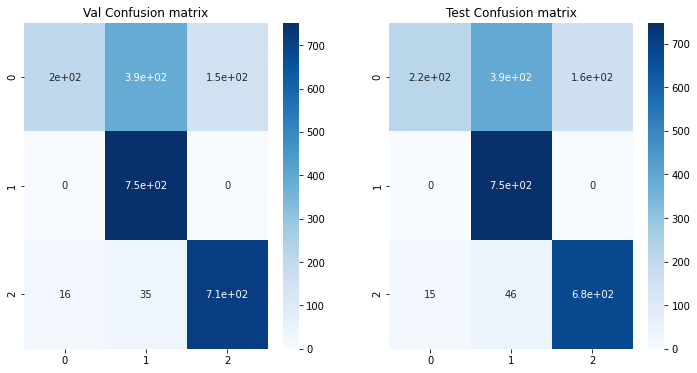

In [152]:
get_accuracy_metrics_for_ANN(ANN, X_train, y_train, X_val, y_val, X_test, y_test)

Train accuracy Score------------>
89.300 %
Val accuracy Score--------->
83.156 %
Test accuracy Score--------->
80.533 %
F1 Score--------------->
79.918 %
Cohen Kappa Score------------->
70.829 %
Recall-------------->
80.533 %
Precision-------------->
80.560 %


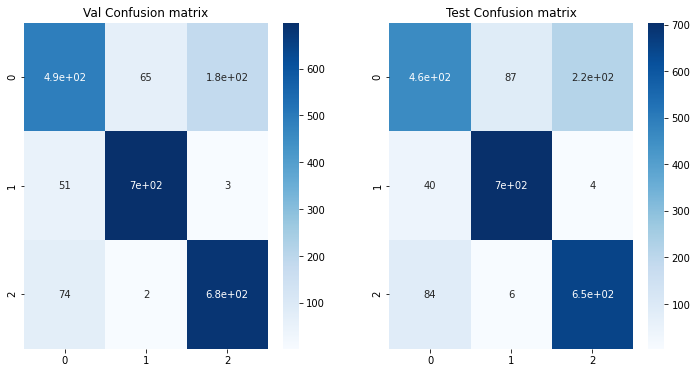

In [153]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

fit_KNN_metrics(KNN, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Train accuracy Score------------>
100.000 %
Val accuracy Score--------->
89.689 %
Test accuracy Score--------->
89.511 %
F1 Score--------------->
89.515 %
Cohen Kappa Score------------->
84.265 %
Recall-------------->
89.511 %
Precision-------------->
89.521 %


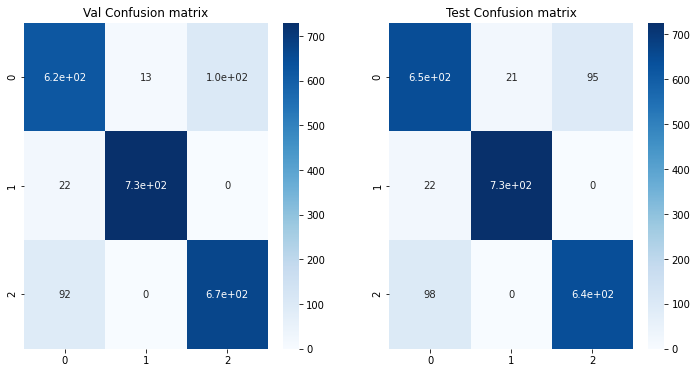

In [154]:
SVM = fit_model(SVM, X_train_scaled, y_train)
get_accuracy_metrics(SVM, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Train accuracy Score------------>
99.990 %
Val accuracy Score--------->
86.267 %
Test accuracy Score--------->
85.378 %
F1 Score--------------->
85.350 %
Cohen Kappa Score------------->
78.060 %
Recall-------------->
85.378 %
Precision-------------->
85.416 %


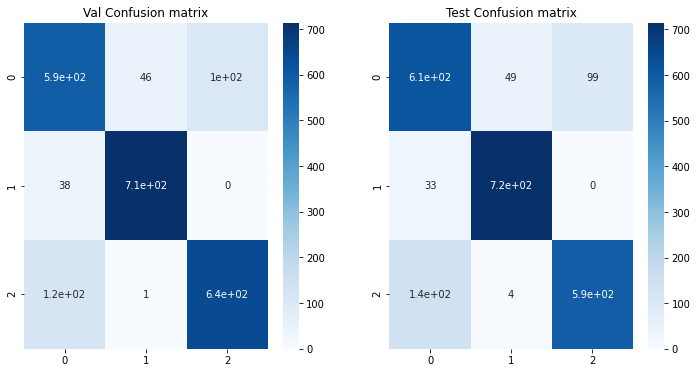

In [155]:
RF = fit_model(RF, X_train, y_train)
get_accuracy_metrics(RF,  X_train, y_train, X_val, y_val, X_test, y_test)

Train accuracy Score------------>
78.962 %
Val accuracy Score--------->
78.089 %
Test accuracy Score--------->
77.689 %
F1 Score--------------->
76.914 %
Cohen Kappa Score------------->
66.572 %
Recall-------------->
77.689 %
Precision-------------->
77.712 %


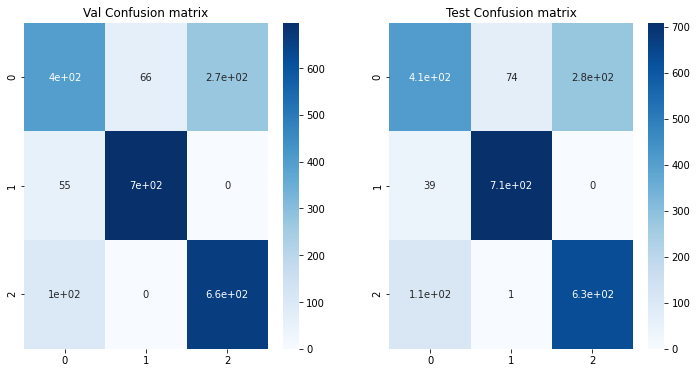

In [156]:
ADB = fit_model(ADB, X_train, y_train)
get_accuracy_metrics(ADB,  X_train, y_train, X_val, y_val, X_test, y_test)